# Portfolio Optimization: Quadratic Programming


A notebook demonstrating the use of modern portfolio theory to find the optimized portfolios under various constraints. Price data is loaded from `.csv` files in the `price_data` directory. Uses the library `cvxpy` to solve the quadratic programs. 

### Imports

In [49]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import datetime
import os

from dateutil import relativedelta

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d

import scipy.stats as stats

import cvxpy as cvx

import warnings
warnings.filterwarnings('ignore')

### Parameters

In [87]:
DATA_DIR = os. getcwd() + '/price_data/'
CMAP = "viridis"

risk_free_rate_annualized = 0.0066 # 10-year U.S. treasury yield
NUM_TRADING_DAYS_YEAR = 252

# Load Data

In [51]:
files = []
for (dirpath, dirnames, filenames) in os.walk(DATA_DIR):
    files.extend(filenames)
    break

In [52]:
data_dict = {}
for file in files:
    key = file.split('_')[0]
    ticker_df = pd.read_csv(DATA_DIR+file)
    if len(ticker_df) == 0:
        continue
    data_dict[key] = ticker_df

# Plotting

## Price Series 
Plot the price series for the loaded data. 

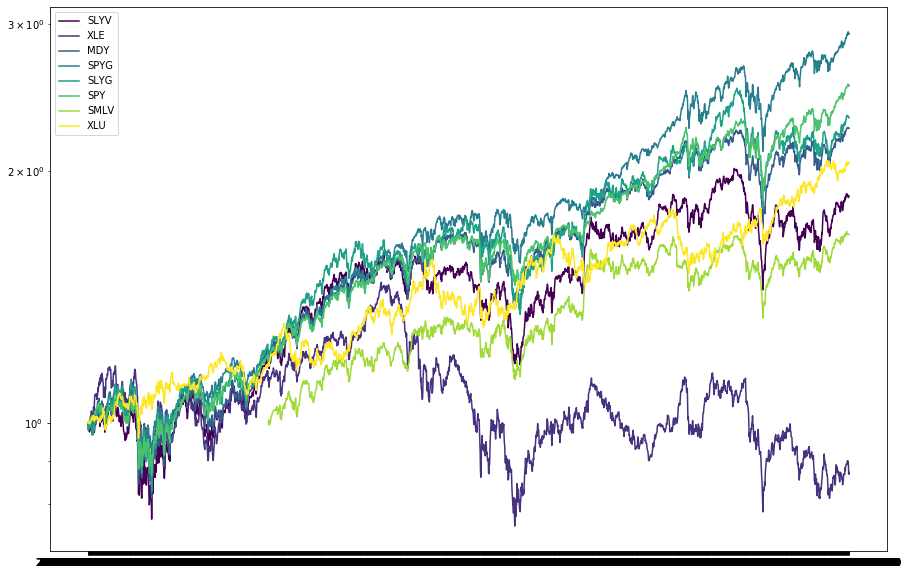

In [53]:

cmap=plt.get_cmap(CMAP)
colors = cmap(np.linspace(0,1,len(data_dict.keys())))

plt.figure(figsize=(15,10))
for i,key in enumerate(data_dict.keys()):
    plt.plot(data_dict[key]['date'],data_dict[key]['close']/data_dict[key]['close'].iloc[0], \
             color = colors[i],label=key)
plt.yscale('log')
plt.legend(loc="upper left")
plt.show()

##  Return and  Covariance Calculations 

### Return Calculations (Interday)

Calculate the interday returns for the loaded price series. 

In [54]:
for key in data_dict.keys():
    df = data_dict[key]
    closing_prices = df['close'].to_numpy()
    
    interday_delta = np.pad(np.diff(closing_prices), (1, 0), 'constant', constant_values=0)
    interday_delta_shifted = np.roll(interday_delta, -1)
    
    returns =np.divide(interday_delta_shifted[:-1],closing_prices[:-1])
    
    #compute excess returns 
    df['interday returns'] = np.pad(returns, (1, 0), 'constant', constant_values=0) -  \
            risk_free_rate_annualized/NUM_TRADING_DAYS_YEAR
    
    data_dict[key] = df

### Normality of Returns

Test for normality of returns using the Shapiro-Wilk test. If p < 0.05, reject the null hypothesis of normality. 

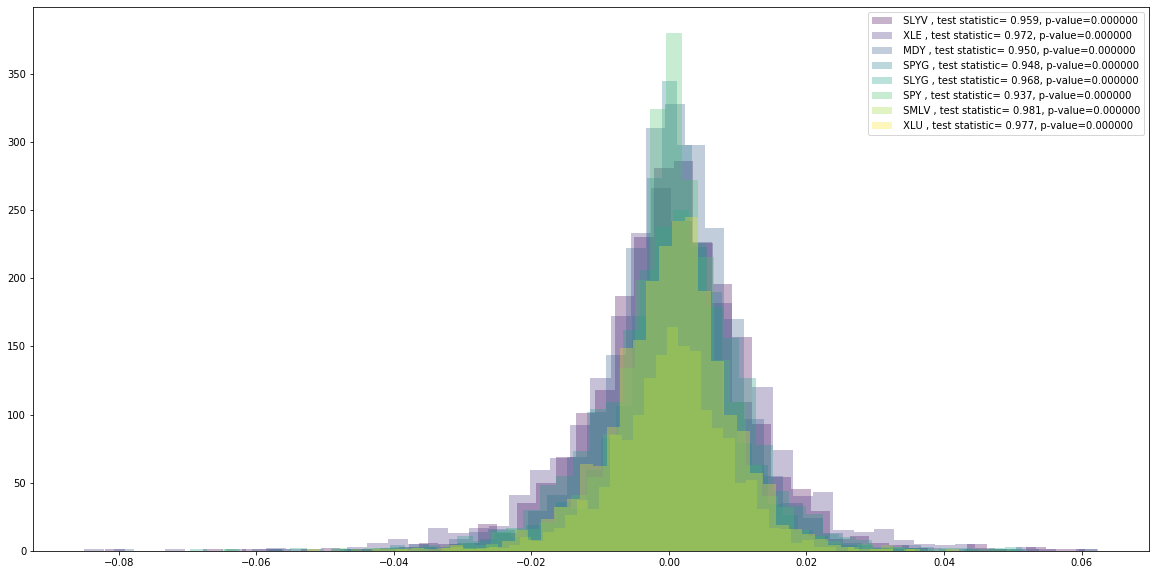

In [55]:
plt.figure(figsize=(20,10))
for i,key in enumerate(data_dict.keys()):
    df = data_dict[key]
    returns = df['interday returns'].to_numpy()
    w, pvalue = stats.shapiro(returns)
    
    label_string = " %s , test statistic= %0.3f, p-value=%f"%(key,w,pvalue)
    
    plt.hist(df['interday returns'].to_numpy(), bins=50, alpha=0.3,color = colors[i], label = label_string)
plt.legend()
plt.show()

### Covariance Matrix

Form the covariance matrix $\Sigma$ for the loaded price series.

In [56]:
# form a dataframe with the interday returns from all symbols 
# join on "date" to ensure returns are properly associated to their time points 
# and the return series for all symbols are time-aligned

consolidated_returns_df = None 
for i,key in enumerate(data_dict.keys()):
    if consolidated_returns_df is None:
        symbol_df = data_dict[key]
        
        #select pertinent columns
        select_columns = ["interday returns", "date"]
        symbol_df = symbol_df[select_columns]
        
        #rename to acommodate merging 
        symbol_df = symbol_df.rename(columns ={"interday returns":key,"close":"close_"+key})
        
        symbol_df = symbol_df.sort_values(by=["date"])
        symbol_df = symbol_df.reset_index(drop=True)
        consolidated_returns_df = symbol_df
        
    else:
        symbol_df = data_dict[key]
        
        #select pertinent columns
        select_columns = ["interday returns", "date"]
        symbol_df = symbol_df[select_columns]
        
        #rename to acommodate merging 
        symbol_df = symbol_df.rename(columns ={"interday returns":key,"close":"close_"+key})
        
        consolidated_returns_df = consolidated_returns_df.merge(symbol_df, left_on='date', right_on='date',suffixes=( None, '_right'))
        
        #drop the extraneous columns 
        consolidated_returns_df = consolidated_returns_df.dropna()

In [57]:
interday_returns = consolidated_returns_df.filter(regex=("^((?!date).)*$")) #select all columns except "date"
correlation_matrix = interday_returns.corr()
correlation_matrix_np = correlation_matrix.to_numpy()

    

In [58]:
#form the returns and covariance matrices 
#mean return vector
M = np.empty(len(data_dict.keys()))
sigmas = np.empty(len(data_dict.keys()))
for i,column in enumerate(interday_returns.columns.values):
    M[i]=NUM_TRADING_DAYS_YEAR*np.average(interday_returns[column], axis=0)
    sigmas[i] = NUM_TRADING_DAYS_YEAR*np.std(interday_returns[column], axis=0)

In [59]:
#form the covariance matrix
sigma_matrix = np.diag(sigmas)
covariance_matrix_np = np.multiply(sigma_matrix,np.multiply(correlation_matrix_np,sigma_matrix ))

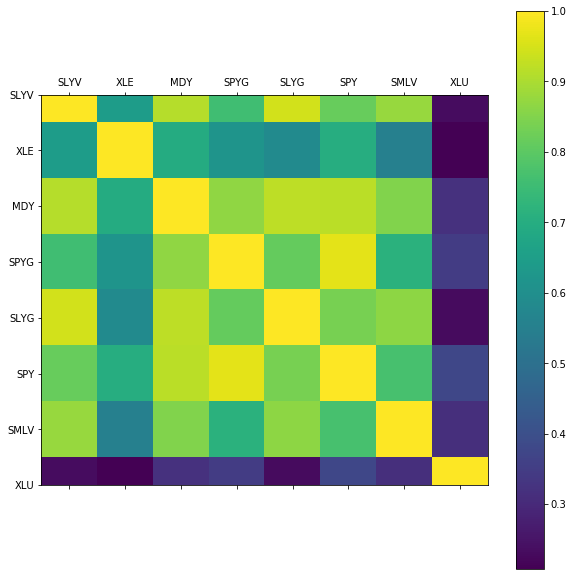

In [60]:
labels = interday_returns.columns.values

plt.figure(figsize=(10,10))
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(ticks = np.arange(len(labels)), labels = labels)
plt.yticks(ticks = np.arange(len(labels)), labels = labels)
plt.colorbar()
plt.show()

# Quadratic Programming: Long-Only Portfiolio, Minimized Risk

Find the minimum risk portfolio for long-only positions in the securities associated with the loaded price data. 

\begin{equation}
\begin{aligned}
\min_{x} \quad & \mathbf{x}^{T}\Sigma \mathbf{x}\\
\textrm{s.t.} \quad & \mathbf{x} \cdot \mathbf{1} = 1.0\\
  &x_i \geq 0    \\
\end{aligned}
\end{equation}

In [61]:
#annualized covariance matrix
C = covariance_matrix_np 

In [62]:
#mean return vector
M = np.empty(len(data_dict.keys()))
for i,column in enumerate(interday_returns.columns.values):
    M[i]=NUM_TRADING_DAYS_YEAR*np.average(interday_returns[column], axis=0)

In [63]:
#CVXPY quadratic programming 
n = len(M)
x = cvx.Variable(n) #portfolio weights
r = cvx.quad_form(x,C) 


In [64]:
constraints = [x>=0]
constraints += [cvx.sum(x)==1]

In [65]:
obj = cvx.Minimize(r)
prob = cvx.Problem(obj, constraints)
prob.solve()
print(prob.status)
print(x.value)

optimal
[0.10259363 0.06642561 0.13440545 0.14387052 0.10327414 0.16212091
 0.14614037 0.14116938]


In [66]:
min_risk_long_only_returns = M.dot(x.value)

### Bar graph for portfolio weights of the minimum risk portfolio

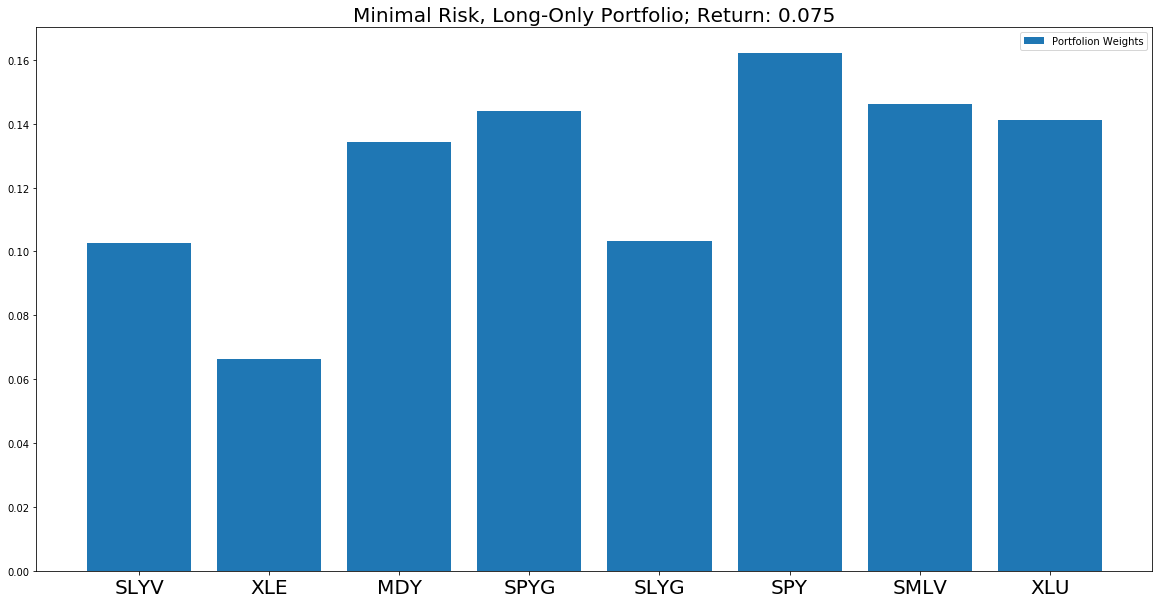

In [67]:
plt.figure(figsize=(20,10))
plt.title("Minimal Risk, Long-Only Portfolio; Return: %0.3f"%min_risk_long_only_returns , fontsize=20)
plt.bar(np.arange(len(labels)), x.value, label = "Portfolion Weights")
plt.xticks(ticks = np.arange(len(labels)), labels = labels, fontsize=20)
plt.legend()
plt.show()

# Quadratic Programming: Long-Only Portfiolio, Maximized Return with Regularized Risk

Maximize return $r$ while including the risk via a regularization parameter $\lambda$.

\begin{equation}
\begin{aligned}
\max_{x} \quad & \mathbf{r}\cdot \mathbf{x} -\lambda \mathbf{x}^{T}\Sigma \mathbf{x}\\
\textrm{s.t.} \quad & \mathbf{x} \cdot \mathbf{1} = 1.0\\
  &x_i \geq 0    \\
\end{aligned}
\end{equation}

In [68]:
lamb = -1.0 #regularization parameter

In [69]:
#CVXPY quadratic programming 
n = len(M)
x = cvx.Variable(n) #portfolio weights
r = cvx.quad_form(x,C)
m = M@x

In [70]:
constraints = [x>=0]
constraints += [cvx.sum(x)==1]


In [71]:
obj = cvx.Maximize(m+lamb*r)
prob = cvx.Problem(obj, constraints)
prob.solve()
print(prob.status)
print(x.value)

optimal
[0.10096068 0.06072674 0.13446892 0.14794927 0.10378839 0.1645023
 0.14671441 0.1408893 ]


In [72]:
max_return_long_only_regularized_returns = M.dot(x.value)

### Bar graph for portfolio weights of the maximum return portfolio

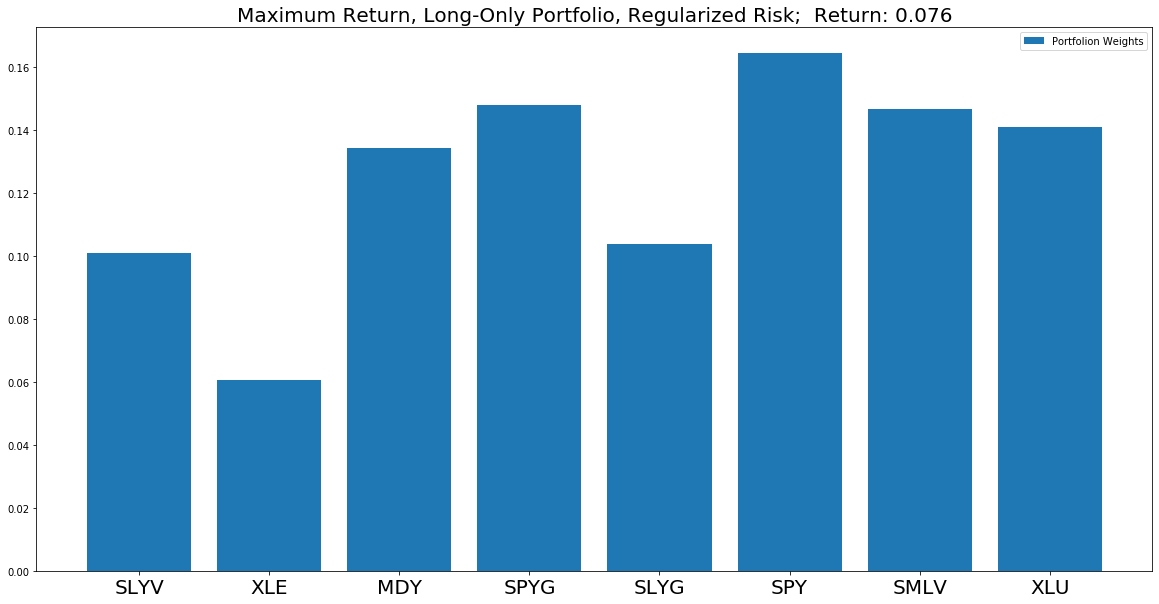

In [73]:
plt.figure(figsize=(20,10))
plt.title("Maximum Return, Long-Only Portfolio, Regularized Risk;  Return: %0.3f"%max_return_long_only_regularized_returns , fontsize=20)
plt.bar(np.arange(len(labels)), x.value, label = "Portfolion Weights")
plt.xticks(ticks = np.arange(len(labels)), labels = labels, fontsize=20)
plt.legend()
plt.show()

# Quadratic Programming: Long-Only Portfiolio, Maximized Return with Constrained Risk



\begin{equation}
\begin{aligned}
\max_{x} \quad & \mathbf{r}\cdot \mathbf{x}\\
\textrm{s.t.} \quad & \mathbf{x} \cdot \mathbf{1} = 1.0\\
  &x_i \geq 0    \\
\end{aligned}
\end{equation}

In [74]:
#CVXPY quadratic programming 
n = len(M)
x = cvx.Variable(n) #portfolio weights
r = cvx.quad_form(x,C)
m = M@x

In [75]:
max_risk = 1.0
constraints = [x>=0]
constraints += [cvx.sum(x)==1]
constraints += [r <= max_risk]



In [76]:
obj = cvx.Maximize(m)
prob = cvx.Problem(obj, constraints)
prob.solve()
print(prob.status)
print(x.value)

optimal
[1.26093753e-07 4.25333398e-09 1.01803421e-01 3.23161969e-01
 1.03081724e-01 2.45881130e-01 1.37662034e-01 8.84095922e-02]


In [77]:
max_return_long_only_constrained_returns = M.dot(x.value)

### Bar graph for portfolio weights of the maximum return portfolio

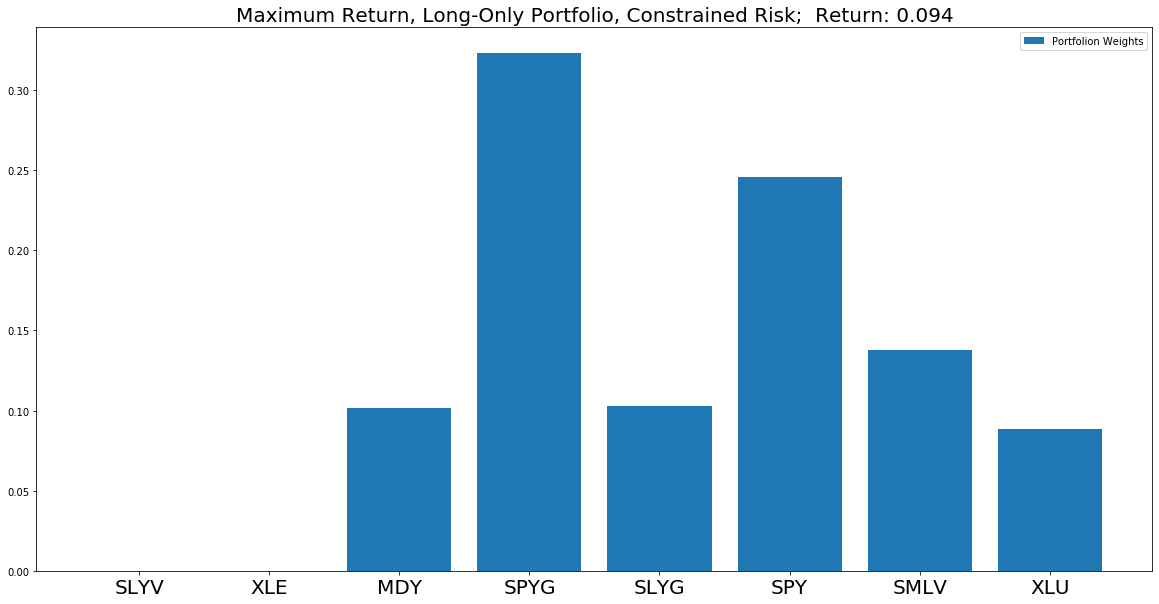

In [78]:
plt.figure(figsize=(20,10))
plt.title("Maximum Return, Long-Only Portfolio, Constrained Risk;  Return: %0.3f"%max_return_long_only_constrained_returns , fontsize=20)
plt.bar(np.arange(len(labels)), x.value, label = "Portfolion Weights")
plt.xticks(ticks = np.arange(len(labels)), labels = labels, fontsize=20)
plt.legend()
plt.show()

## Quadratic Programming: Long-Only Portfiolio, Maximized Return with Constrained Risk _Frontier_


                               for max_risk in range(1.0,5.0):
\begin{equation}
\begin{aligned}
\max_{x} \quad & \mathbf{r}\cdot \mathbf{x} \\
\textrm{s.t.} \quad & \mathbf{x} \cdot \mathbf{1} = 1.0\\
  &x_i \geq 0    \\
    &\mathbf{x}^{T}\Sigma \mathbf{x} \leq \text{max_risk} \\
\end{aligned}
\end{equation}

In [79]:
max_risk_vec = np.linspace(0.8,5,20)

In [80]:
weight_matrix = np.empty((len(max_risk_vec),n))

In [81]:
n = len(M)
x = cvx.Variable(n) #portfolio weights
r = cvx.quad_form(x,C)
m = M@x

In [82]:
for i,max_risk in enumerate(max_risk_vec):
    constraints = [x>=0]
    constraints += [cvx.sum(x)==1]
    constraints += [r <= max_risk]
    
    obj = cvx.Maximize(m)
    prob = cvx.Problem(obj, constraints)
    prob.solve()
    
    weight_matrix[i,:] = x.value
    

### Maximum-return portfolio weights by position as a function of risk constraint

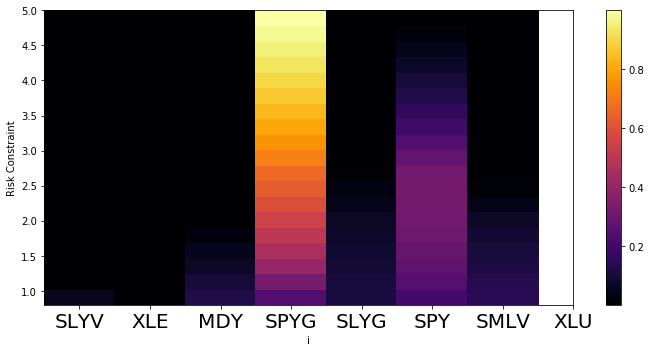

In [83]:
#colormesh plot
symbol_nums = np.array([[i for j in range(len(max_risk_vec))] for i in range(n)])
risk_constraint = np.tile(max_risk_vec,(n,1))

plt.figure(figsize=(10,5))
plt.pcolormesh(symbol_nums,risk_constraint,weight_matrix.transpose(), cmap="inferno")
plt.ylabel('Risk Constraint')
plt.xlabel('i')
plt.xticks(ticks = np.arange(len(labels))+0.5, labels = labels, fontsize=20)
plt.colorbar()
plt.tight_layout()
plt.show()

    

### Maximum-return portfolio weights by position as a function of risk constraint (surface plot)

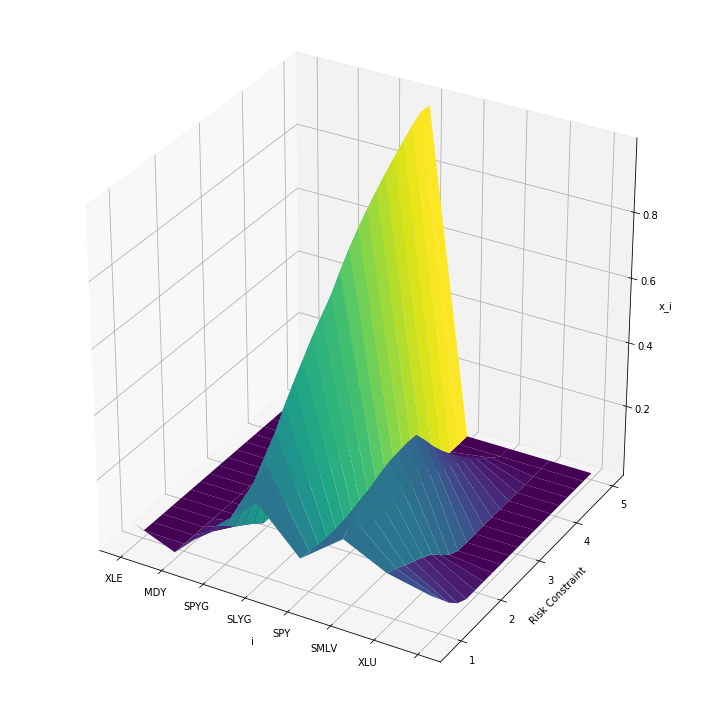

In [84]:
#3D plot
#%matplotlib notebook
symbol_nums = np.array([[i for j in range(len(max_risk_vec))] for i in range(n)])
risk_constraint = np.tile(max_risk_vec,(n,1))


fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(symbol_nums, risk_constraint, weight_matrix.transpose(), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('i')
ax.set_ylabel('Risk Constraint')
ax.set_zlabel('x_i')
ax.set_xticklabels(labels)
plt.tight_layout()
plt.show()

In [85]:
portfolio_returns = np.empty(len(max_risk_vec))

for i,max_risk in enumerate(max_risk_vec):
    portfolio_returns[i] = weight_matrix[i,:].dot(M)



## Efficient Frontier for the Long-only Portfolio

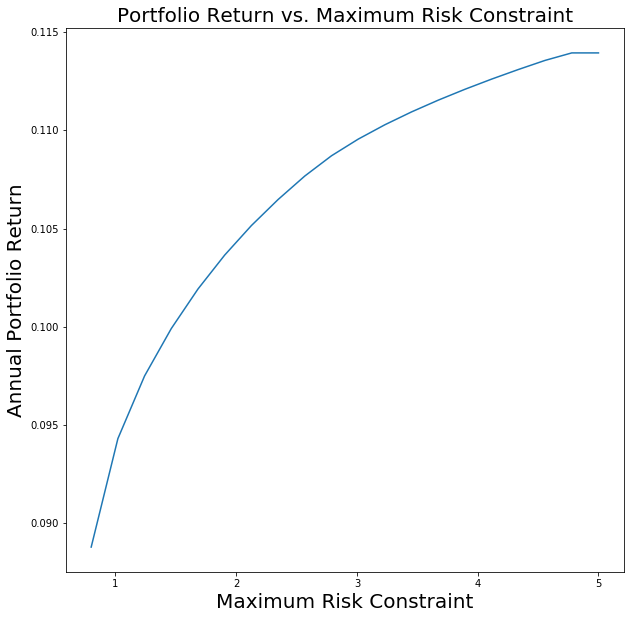

In [86]:
plt.figure(figsize=(10,10))
plt.title("Portfolio Return vs. Maximum Risk Constraint", fontsize=20)
plt.plot(max_risk_vec,portfolio_returns )
plt.xlabel("Maximum Risk Constraint", fontsize=20)
plt.ylabel("Annual Portfolio Return", fontsize=20)
plt.show()